In [1]:
# Install Kaggle API
!pip install -q kaggle

# Upload your kaggle.json
from google.colab import files
files.upload()  # Select the kaggle.json file

# Set up permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Critical!

# Download the dataset
!kaggle competitions download -c iuss-23-24-automatic-diagnosis-breast-cancer

# Unzip (ignore warnings)
!unzip iuss-23-24-automatic-diagnosis-breast-cancer.zip

Saving kaggle.json to kaggle.json
 76% 222M/293M [00:00<00:00, 673MB/s] 
100% 293M/293M [00:00<00:00, 606MB/s]
Archive:  iuss-23-24-automatic-diagnosis-breast-cancer.zip
  inflating: complete_set/testing_set/P001.png  
  inflating: complete_set/testing_set/P001_mask.png  
  inflating: complete_set/testing_set/P002.png  
  inflating: complete_set/testing_set/P002_mask.png  
  inflating: complete_set/testing_set/P003.png  
  inflating: complete_set/testing_set/P003_mask.png  
  inflating: complete_set/testing_set/P004.png  
  inflating: complete_set/testing_set/P004_mask.png  
  inflating: complete_set/testing_set/P005.png  
  inflating: complete_set/testing_set/P005_mask.png  
  inflating: complete_set/testing_set/P006.png  
  inflating: complete_set/testing_set/P006_mask.png  
  inflating: complete_set/testing_set/P007.png  
  inflating: complete_set/testing_set/P007_mask.png  
  inflating: complete_set/testing_set/P008.png  
  inflating: complete_set/testing_set/P008_mask.png  
  infl

In [2]:
!ls  # Should show files like 'train.csv', 'test.csv'

complete_set					  sample_data
iuss-23-24-automatic-diagnosis-breast-cancer.zip  training_set


In [3]:
# Unzip the file (if not already done)
!unzip -q iuss-23-24-automatic-diagnosis-breast-cancer.zip -d ./data

# Check contents of the 'training_set' folder
!ls training_set

benign	malignant


In [4]:
import os
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
import numpy as np

# Initialize lists
image_paths = []
labels = []
features = []  # For extracted image features

# Scan folders
for label in ['benign', 'malignant']:
    folder_path = os.path.join('training_set', label)
    for img_file in os.listdir(folder_path):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            # Store paths and labels
            image_paths.append(os.path.join(folder_path, img_file))
            labels.append(0 if label == 'benign' else 1)  # 0=benign, 1=malignant

            # Optional: Extract basic image features
            img = imread(image_paths[-1])
            img_resized = resize(img, (128, 128))  # Standardize size
            features.append(img_resized.flatten())  # Flatten pixels

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels,
    # Add metadata if available (e.g., patient_age from filenames)
})

# Add flattened image features
if features:
    df = pd.concat([df, pd.DataFrame(features)], axis=1)

print(f"Loaded {len(df)} images")
print(df.head())

Loaded 1112 images
                                  image_path  label         0         1  \
0   training_set/benign/benign (52)_mask.png      0     False     False   
1       training_set/benign/benign (303).png      0  0.458705  0.458705   
2   training_set/benign/benign (66)_mask.png      0     False     False   
3  training_set/benign/benign (113)_mask.png      0     False     False   
4       training_set/benign/benign (204).png      0  0.362888  0.362888   

          2         3         4         5         6         7  ... 65526  \
0     False     False     False     False     False     False  ...   NaN   
1  0.458705  0.150087  0.150087  0.150087  0.438755  0.438755  ...   NaN   
2     False     False     False     False     False     False  ...   NaN   
3     False     False     False     False     False     False  ...   NaN   
4  0.362888  0.470183  0.470183  0.470183  0.370353  0.370353  ...   NaN   

  65527 65528 65529 65530 65531 65532 65533 65534 65535  
0   NaN   NaN  

In [5]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df.drop(['image_path', 'label'], axis=1)  # Use pixel features
y = df['label'].map({0: 'low', 1: 'high'})  # Convert to priority labels

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # Preserve class balance
    random_state=42
)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Initialize and train model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',  # Handles class imbalance
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")

Accuracy: 0.78
F1 Score: 0.77



Classification Report:
              precision    recall  f1-score   support

         low       0.63      0.53      0.58        64
        high       0.82      0.87      0.85       159

    accuracy                           0.78       223
   macro avg       0.73      0.70      0.71       223
weighted avg       0.77      0.78      0.77       223



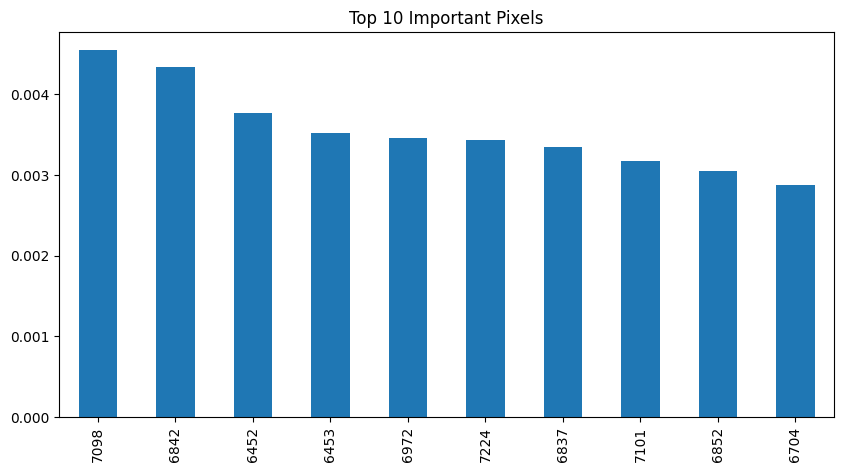

In [7]:
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['low', 'high']))

# Feature importance (top 10 pixels)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
pd.Series(model.feature_importances_).sort_values(ascending=False)[:10].plot(kind='bar')
plt.title("Top 10 Important Pixels")
plt.show()